In [1]:
import matplotlib.pyplot as plt
import torch

import networkx as nx
import tensorlayerx as tlx
from gammagl.data import Graph

Using PyTorch backend.


Gammagl Global Config Info:
    TLX_BACKEND: torch
    DATASET_ROOT: C:\Users\mi\.ggl\datasets


In [2]:
edge_index = tlx.convert_to_tensor([[0, 1, 1, 2], [1, 0, 2, 1]])
x = tlx.eye(3)

In [3]:
g = Graph(x=x, edge_index=edge_index)

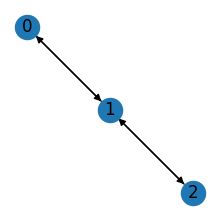

In [4]:
from torch_geometric.utils import to_networkx

plt.figure(figsize=(2, 2))
nx.draw(to_networkx(g), with_labels=True)

In [5]:
print(edge_index)
print(x)

tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]])
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])


In [6]:
tlx.gather(x,edge_index[0])

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])

## GCN
$$
\mathbf{x}_i^{(k)} = \sum_{j \in \mathcal{N}(i) \cup \{ i \}} \frac{1}{\sqrt{\deg(i)} \cdot \sqrt{\deg(j)}} \cdot \left( \mathbf{\Theta}^{\top} \cdot \mathbf{x}_j^{(k-1)} \right),
$$

In [7]:
from gammagl.layers.conv import MessagePassing
from gammagl.utils import add_self_loops, degree

In [23]:
class GCNConv(MessagePassing):
    def __init__(self, in_feats, out_feats):
        super().__init__()
        self.lin = tlx.layers.Linear(5)

    def forward(self, x, edge_index):
        edge_index, edge_attr = add_self_loops(edge_index, num_nodes=x.shape[0])
        print('so far so good')
        x = self.lin(x)

        in_deg = degree(edge_index[1], num_nodes=x.shape[0]).pow(-0.5)
        out_deg = degree(edge_index[0], num_nodes=x.shape[0]).pow(-0.5)

        deg_i = in_deg[edge_index[1]]
        deg_j = out_deg[edge_index[0]]
        norm = deg_i * deg_j
        
        self.propagate(x,edge_index,norm=norm)

    def message(self,x_j,edge_index,norm):
        
        

In [24]:
model=GCNConv(3,4)


[TLX] Linear  linear_8: 5 No Activation


In [25]:
model(x,edge_index)

so far so good


E:\Anacodna3\envs\GML\lib\site-packages\tensorlayerx\backend\ops\torch_backend.py:1631: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  segment_ids = torch.tensor(segment_ids, dtype=torch.int64)


TypeError: Required parameter x_j is empty.

In [ ]:
self.linear = tlx.layers.Linear(out_features=out_channels,
                                        in_features=in_channels,
                                        W_init='xavier_uniform',
                                        b_init=None)

In [22]:
lin=tlx.layers.Linear(out_features=4,in_features=3)
x = tlx.eye(3)
lin(x)

[TLX] Linear  linear_7: 4 No Activation


tensor([[ 0.0065,  0.0086, -0.0309,  0.0336],
        [ 0.0064,  0.0366,  0.0004,  0.0149],
        [-0.0152, -0.0258, -0.0013,  0.0080]], grad_fn=<AddmmBackward0>)

## example

In [16]:
import tensorlayerx as tlx
from gammagl.layers.conv import MessagePassing
from gammagl.utils import add_self_loops, degree
from gammagl.mpops import unsorted_segment_sum

class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels, add_bias):
        super().__init__()
        self.lin = tlx.layers.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.shape[0])

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 3: Compute edge weight.
        src, dst = edge_index[0], edge_index[1]
        edge_weight = tlx.ones(shape=(edge_index.shape[1], 1))
        deg = degree(dst, num_nodes=x.shape[0])
        deg_inv_sqrt = tlx.pow(deg, -0.5)
        weights = tlx.ops.gather(deg_inv_sqrt, src) * tlx.reshape(edge_weight, (-1,)) * tlx.ops.gather(deg_inv_sqrt, dst)

        # Step 4-5: Start propagating messages.
        return self.propagate(x, edge_index, edge_weight=weights, num_nodes=x.shape[0], aggr_type='sum')

    def message(self, x, edge_index, edge_weight):
        msg = tlx.gather(x, edge_index[0, :])
        return msg * edge_weight

In [17]:
gcn=GCNConv(3,4,add_bias=False)

[TLX] Linear  linear_4: 3 int


In [18]:
gcn(x,edge_index)

TypeError: 'int' object is not callable

In [21]:
from gammagl.layers.conv import GCNConv
gcn = GCNConv(3, 5)
gcn(x, edge_index)


[TLX] Linear  linear_6: 5 No Activation


E:\Anacodna3\envs\GML\lib\site-packages\tensorlayerx\backend\ops\torch_backend.py:1631: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  segment_ids = torch.tensor(segment_ids, dtype=torch.int64)


tensor([[ 0.2832,  0.1196,  0.3506,  0.3415, -0.1409],
        [-0.1429, -0.8805, -0.6048, -0.0665, -0.9212],
        [ 0.2832,  0.1196,  0.3506,  0.3415, -0.1409]], grad_fn=<AddBackward0>)